# **Task 1**

In [77]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip install "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.


In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import STL10
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import torch.nn.functional as F
import torchvision

In [120]:
# Helper Functions

# Compose all image transforms (resize + grayscale + to tensor)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

def add_noise(x, std):
    noise = torch.randn_like(x) * std
    return torch.clamp(x + noise, 0., 1.)

def psnr(mse, max_val=1.0):
    return float('inf') if mse == 0 else 10 * math.log10(max_val**2 / mse)

# 2️⃣ Dataset: select 100 STL10 training images and apply transforms

raw_train = STL10(root='./data', split='train', download=True, transform=transform)
small_train = Subset(raw_train, list(range(100)))  # use first 100 images for training


Files already downloaded and verified


In [122]:
# Class to provide clear and noisy image pairs for training

class NoisyDS(Dataset):
    def __init__(self, base_ds, noise_std_range=(0.05, 0.15)):
        self.base = base_ds
        self.noise_std_range = noise_std_range  # range for noise std scheduling

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]
        clean = img  # already tensor (1,64,64) grayscale normalized [0,1]

        # Sample noise std randomly from range for noise scheduling
        noise_std = random.uniform(*self.noise_std_range)
        noisy = add_noise(clean, noise_std)
        return noisy, clean

In [124]:
# Create train/val splits from noisy dataset

noisy_ds = NoisyDS(small_train)
n_train = int(0.8 * len(noisy_ds))
train_ds, val_ds = random_split(noisy_ds, [n_train, len(noisy_ds) - n_train])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

In [126]:
# Define improved U-Net style Autoencoder with skip connections and BatchNorm

class UNetAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder blocks: Conv2d -> BatchNorm -> ReLU
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU())
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU())

        # Decoder blocks: ConvTranspose2d -> BatchNorm -> ReLU
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), nn.ReLU())
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32), nn.ReLU())
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())  # output range [0,1]

    def forward(self, x):
        # Encode
        e1 = self.enc1(x)  # [B,32,32,32]
        e2 = self.enc2(e1) # [B,64,16,16]
        e3 = self.enc3(e2) # [B,128,8,8]

        # Decode with skip connections (concatenate along channel dim)
        d3 = self.dec3(e3)         # [B,64,16,16]
        d3_cat = torch.cat([d3, e2], dim=1)  # [B,128,16,16]

        d2 = self.dec2(d3_cat)     # [B,32,32,32]
        d2_cat = torch.cat([d2, e1], dim=1)  # [B,64,32,32]

        d1 = self.dec1(d2_cat)     # [B,1,64,64]
        return d1


In [128]:
model = UNetAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

/Users/hamzaiqbal/Documents/Practice Area/Langchain Project/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


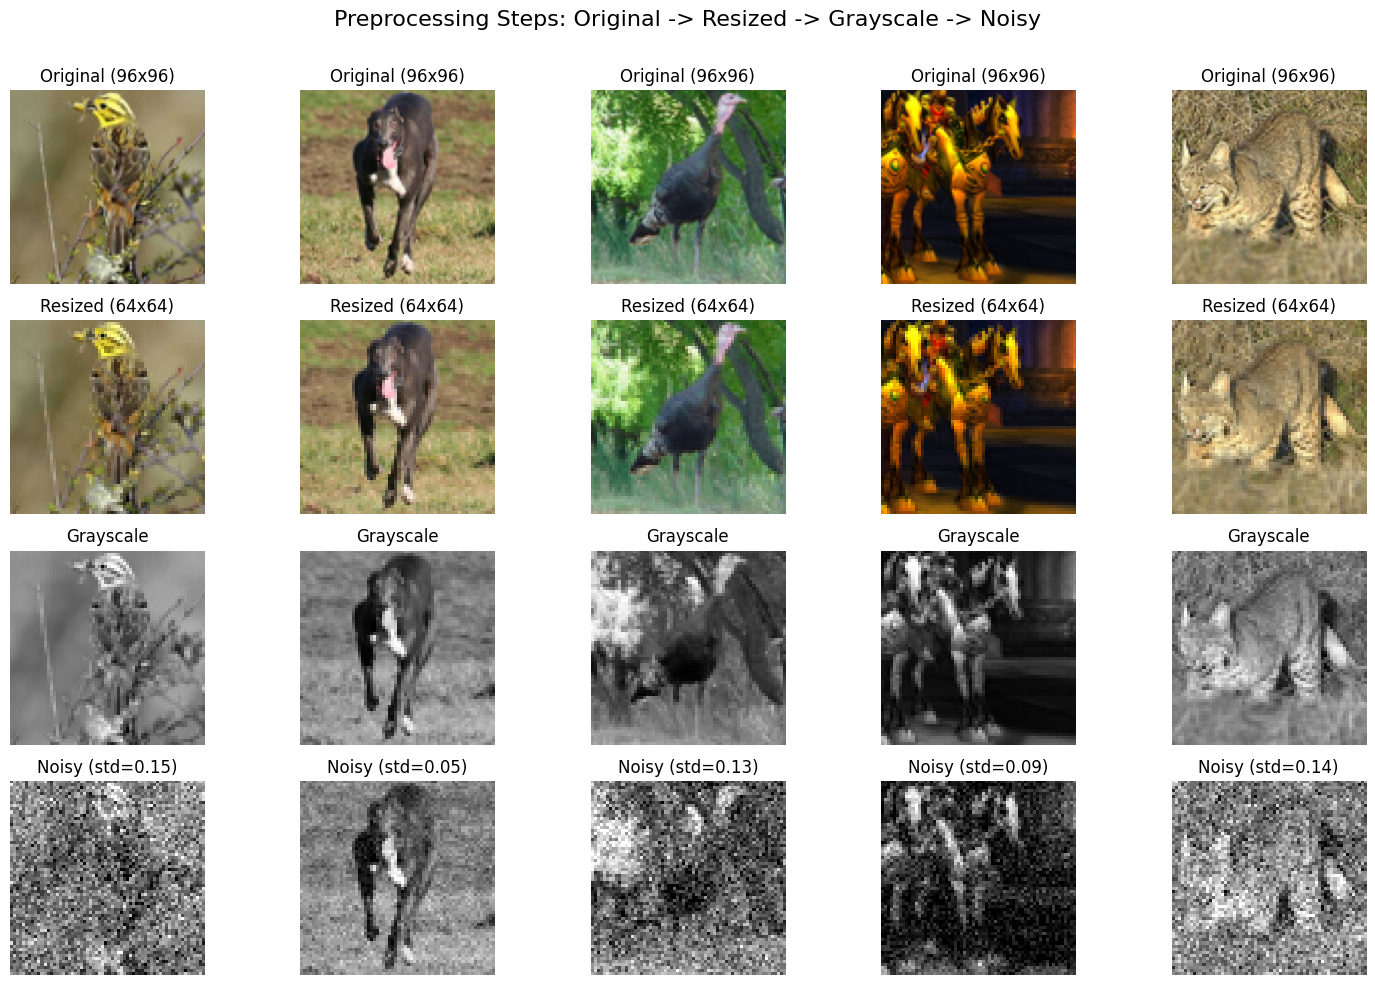

In [144]:
## This display is for just analysis to see the images and process that how we are doing.

def show_preprocessing_samples(raw_dataset, num_samples=5, noise_std_range=(0.05, 0.15)):
    import torchvision.transforms.functional as F
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 10))
    fig.suptitle("Preprocessing Steps: Original -> Resized -> Grayscale -> Noisy", fontsize=16)
    
    # Load images without transform to get original PIL images
    raw_no_transform = STL10(root='./data', split='train', download=False, transform=None)
    
    for i in range(num_samples):
        pil_img, _ = raw_no_transform[i]
        
        # Row 1: Original 96x96 image
        axes[0, i].imshow(pil_img)
        axes[0, i].set_title("Original (96x96)")
        axes[0, i].axis('off')

        # Row 2: Resized image (64x64)
        resized_img = pil_img.resize((64,64))
        axes[1, i].imshow(resized_img)
        axes[1, i].set_title("Resized (64x64)")
        axes[1, i].axis('off')

        # Row 3: Grayscale image
        grayscale_img = resized_img.convert('L')
        axes[2, i].imshow(grayscale_img, cmap='gray')
        axes[2, i].set_title("Grayscale")
        axes[2, i].axis('off')

        # Row 4: Noisy grayscale image
        tensor_img = transforms.ToTensor()(grayscale_img)
        noise_std = random.uniform(*noise_std_range)
        noisy_img = add_noise(tensor_img, noise_std)
        noisy_np = noisy_img.squeeze().numpy()
        axes[3, i].imshow(noisy_np, cmap='gray')
        axes[3, i].set_title(f"Noisy (std={noise_std:.2f})")
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call before training
show_preprocessing_samples(raw_train)


In [134]:
# 4️⃣ Training loop with 30 epochs, noise scheduling already in dataset

epochs = 30
train_losses = []
val_losses = []
train_psnrs = []
val_psnrs = []

for ep in range(epochs):
    model.train()
    running_loss = 0
    running_psnr = 0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        mse = ((outputs - clean)**2).mean().item()
        running_psnr += psnr(mse)

    avg_train_loss = running_loss / len(train_loader)
    avg_train_psnr = running_psnr / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_psnr = 0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            val_loss += loss.item()
            mse = ((outputs - clean)**2).mean().item()
            val_psnr += psnr(mse)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_psnr = val_psnr / len(val_loader)

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_psnrs.append(avg_train_psnr)
    val_psnrs.append(avg_val_psnr)

    print(f"Epoch {ep+1}/{epochs}: Train MSE={avg_train_loss:.4f}, Val MSE={avg_val_loss:.4f}, "
          f"Train PSNR={avg_train_psnr:.2f}, Val PSNR={avg_val_psnr:.2f}")


Epoch 1/30: Train MSE=0.0921, Val MSE=0.0669, Train PSNR=10.50, Val PSNR=11.82
Epoch 2/30: Train MSE=0.0507, Val MSE=0.0500, Train PSNR=12.98, Val PSNR=13.07
Epoch 3/30: Train MSE=0.0322, Val MSE=0.0360, Train PSNR=14.99, Val PSNR=14.47
Epoch 4/30: Train MSE=0.0227, Val MSE=0.0261, Train PSNR=16.50, Val PSNR=15.84
Epoch 5/30: Train MSE=0.0176, Val MSE=0.0196, Train PSNR=17.56, Val PSNR=17.08
Epoch 6/30: Train MSE=0.0143, Val MSE=0.0153, Train PSNR=18.46, Val PSNR=18.16
Epoch 7/30: Train MSE=0.0134, Val MSE=0.0124, Train PSNR=18.75, Val PSNR=19.06
Epoch 8/30: Train MSE=0.0114, Val MSE=0.0101, Train PSNR=19.45, Val PSNR=19.97
Epoch 9/30: Train MSE=0.0127, Val MSE=0.0099, Train PSNR=19.05, Val PSNR=20.04
Epoch 10/30: Train MSE=0.0101, Val MSE=0.0096, Train PSNR=19.97, Val PSNR=20.22
Epoch 11/30: Train MSE=0.0090, Val MSE=0.0076, Train PSNR=20.46, Val PSNR=21.21
Epoch 12/30: Train MSE=0.0082, Val MSE=0.0075, Train PSNR=20.90, Val PSNR=21.24
Epoch 13/30: Train MSE=0.0076, Val MSE=0.0066, Tr

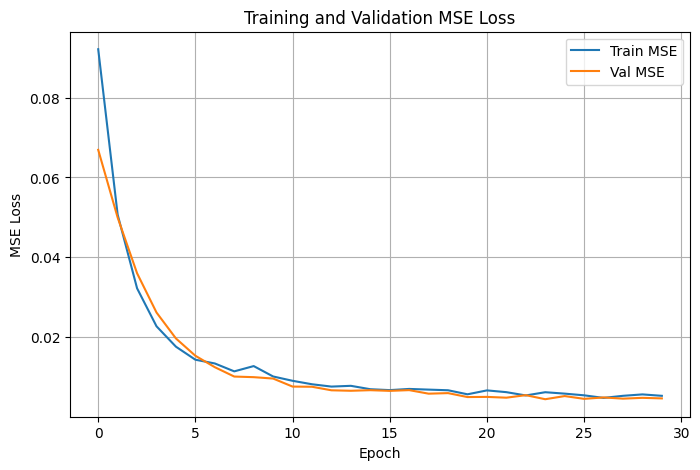

In [136]:
# 5️⃣ Plot quantitative performance

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

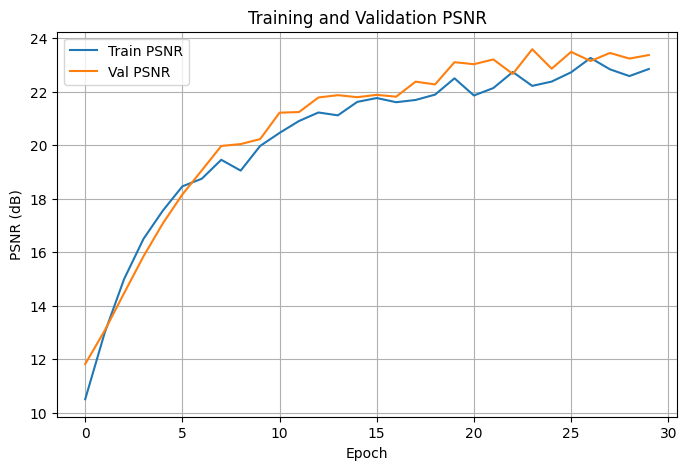

In [138]:
plt.figure(figsize=(8, 5))
plt.plot(train_psnrs, label='Train PSNR')
plt.plot(val_psnrs, label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Training and Validation PSNR')
plt.legend()
plt.grid(True)
plt.show()

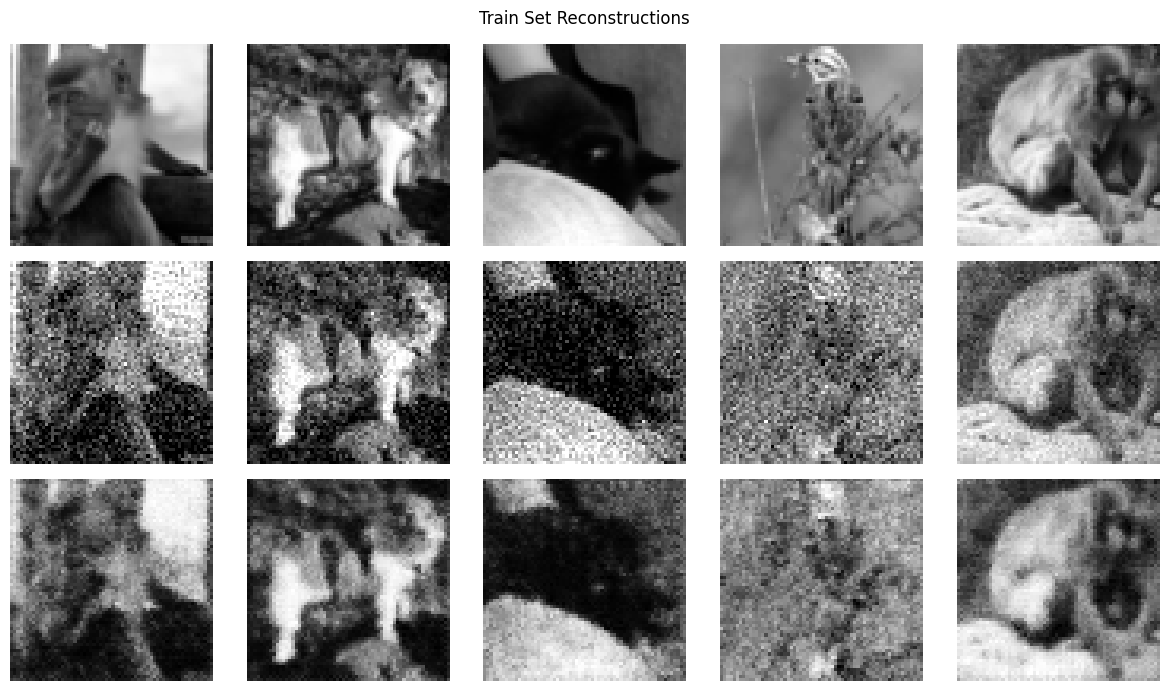

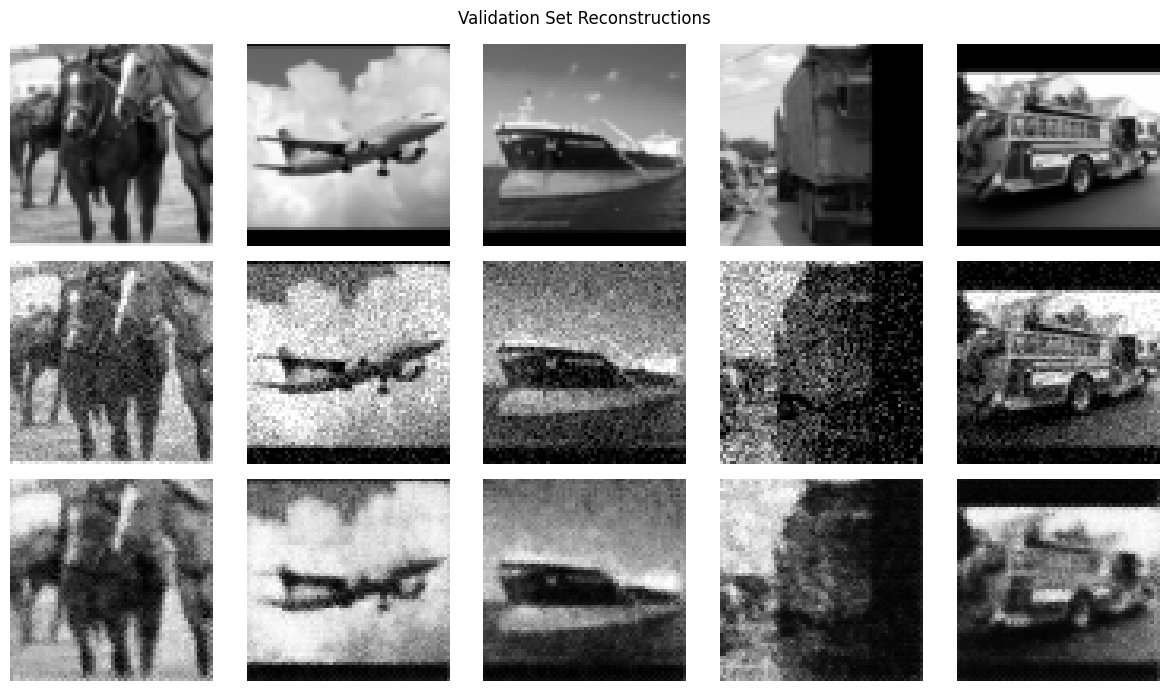

In [146]:
# This displays how our model doing while training phase, displaying clear, noisy and recconstructed image by model

def show_samples(loader, title):
    model.eval()
    noisy, clean = next(iter(loader))
    noisy, clean = noisy[:5], clean[:5]
    with torch.no_grad():
        recon = model(noisy.to(device)).cpu()
    fig, ax = plt.subplots(3, 5, figsize=(12, 7))
    fig.suptitle(title)
    rows = ['Clean', 'Noisy', 'Reconstructed']
    for r in range(3):
        ax[r, 0].set_ylabel(rows[r], fontsize=14)
        for i in range(5):
            img = [clean, noisy, recon][r][i].squeeze()
            ax[r, i].imshow(img, cmap='gray')
            ax[r, i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_loader, "Train Set Reconstructions")
show_samples(val_loader, "Validation Set Reconstructions")


Files already downloaded and verified

👉 Final Test Results: MSE=0.0045, PSNR=23.45 dB


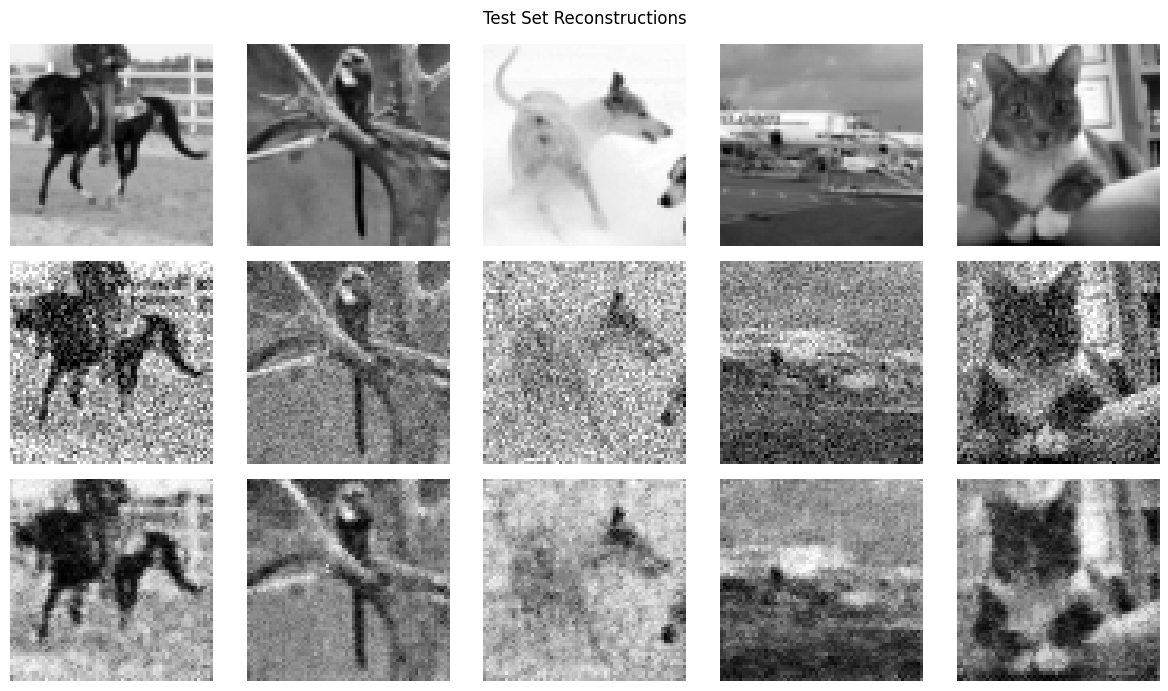

In [142]:
# Final reconstruction on totally unseen dataset

raw_test = STL10(root='./data', split='test', download=True, transform=transform)
test_ds = NoisyDS(raw_test)  # same noise scheduling during test
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model.eval()
test_loss = 0
test_psnr = 0
with torch.no_grad():
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        test_loss += loss.item()
        mse = ((outputs - clean)**2).mean().item()
        test_psnr += psnr(mse)

avg_test_loss = test_loss / len(test_loader)
avg_test_psnr = test_psnr / len(test_loader)
print(f"\n Final Test Results: MSE={avg_test_loss:.4f}, PSNR={avg_test_psnr:.2f} dB")

# Visualize some test reconstructions
show_samples(test_loader, "Test Set Reconstructions")


# Analysis
## *The reconstruction results show that the model effectively removes noise from the images, producing clear outputs on both training and test sets. The similar quality between training and test reconstructions indicates good generalization without significant overfitting. Some minor blurring occurs, but overall the model performs well in denoising grayscale STL10 images.*

# **Task 2**

In [155]:
## Determining the randomness

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [163]:
# Dataset ingestion and transformation into tensors

transform = transforms.Compose([transforms.ToTensor()])
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

indices = random.sample(range(len(cifar10)), 100)
subset = torch.utils.data.Subset(cifar10, indices)
data_loader = DataLoader(subset, batch_size=2, shuffle=True)


100%|███████████████████████| 170498071/170498071 [00:07<00:00, 22621596.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [165]:
# Image pairs and labels preparation happening in this funcition

def prepare_pairs(batch):
    pairs = []
    labels = []
    for i in range(0, len(batch[0]), 2):
        img1 = batch[0][i]
        img2 = batch[0][i + 1]

        original_order = torch.cat([img1, img2], dim=0)
        
        if random.random() > 0.5:
            receiver_order = torch.cat([img1, img2], dim=0)
            label = 1
        else:
            receiver_order = torch.cat([img2, img1], dim=0)
            label = 0

        pairs.append((original_order, receiver_order))
        labels.append(label)

    return pairs, torch.tensor(labels, dtype=torch.float32)

pairs_list = []
labels_list = []

# Saving the 50 pairs in the pairs and labels list
for batch in data_loader:
    pairs, labels = prepare_pairs(batch)
    pairs_list.extend(pairs)
    labels_list.extend(labels)


class ImageOrderDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        original, receiver = self.pairs[idx]
        return original, receiver, self.labels[idx]

dataset = ImageOrderDataset(pairs_list, labels_list)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)


In [167]:
# Defining Sender and Receiver nodes architechture doing forward and backward propagation to learn patterns

class Sender(nn.Module):
    def __init__(self):
        super(Sender, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(6, 16, 3, stride=1, padding=1),  # 6 channels (stacked 3+3)
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # 1-bit message
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.cnn(x)

class Receiver(nn.Module):
    def __init__(self):
        super(Receiver, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(6, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 16 * 16 + 1, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x, message):
        x = self.cnn[0:4](x)
        x = torch.cat([x, message.unsqueeze(1)], dim=1)
        x = self.cnn[4:](x)
        return x


In [169]:
# Model Training Loop demonstrating Loss  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sender = Sender().to(device)
receiver = Receiver().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=0.001)

losses = []

for epoch in range(10):
    total_loss = 0.0
    for orig, recv, label in train_loader:
        orig, recv, label = orig.to(device), recv.to(device), label.to(device)

        message = sender(orig).squeeze()
        output = receiver(recv, message).squeeze()

        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.7075
Epoch 2, Loss: 0.6722
Epoch 3, Loss: 0.6532
Epoch 4, Loss: 0.6650
Epoch 5, Loss: 0.6222
Epoch 6, Loss: 0.6069
Epoch 7, Loss: 0.5758
Epoch 8, Loss: 0.5534
Epoch 9, Loss: 0.5285
Epoch 10, Loss: 0.4910


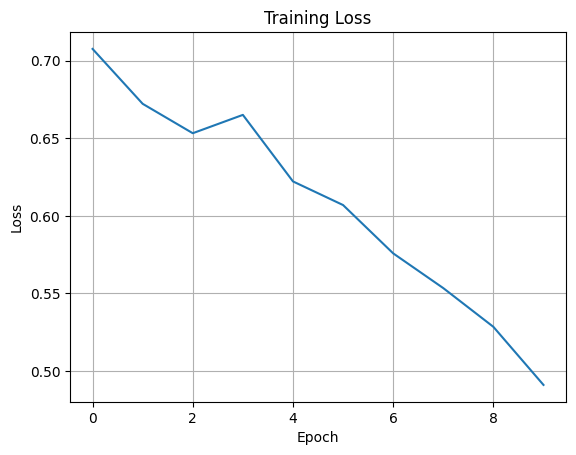

In [171]:
## Visual representation of Training Loss

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [173]:
# Final Classification Error Rate demonstrate that the model is learning with minimum error rate

correct = 0
total = 0

with torch.no_grad():
    for orig, recv, label in train_loader:
        orig, recv, label = orig.to(device), recv.to(device), label.to(device)

        message = sender(orig).squeeze()
        output = receiver(recv, message).squeeze()

        predicted = (output > 0.5).float()
        correct += (predicted == label).sum().item()
        total += label.size(0)

error_rate = 100 * (1 - correct / total)
print(f"\nFinal Classification Error Rate: {error_rate:.2f}%")



Final Classification Error Rate: 14.00%


# Analysis
## *The model did really well! It learned to use one simple bit (like a yes/no) to tell which image came first, and the receiver figured it out with only a 14% error rate, which is way better than random guessing. The training got better over time, which means it learned something genuine. But we only used 100 images and tested on the same ones, so it might just be memorizing. To be sure it’s smart and not just lucky, we should test it on new image pairs.*